In [11]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


%matplotlib inline

from reco.matching import get_highest_energy_fraction_simtracksters
from reco.energy import get_total_energy
from reco.plotting import plot_event, plot_remapped
from reco.evaluation import evaluate, evaluate_remapped
from reco.features import longest_path_from_highest_centrality, mean_edge_length, mean_edge_energy_gap
from reco.graph_utils import create_graph

# file_name = "~/Data/pions/new_ntuples_14955802_7.root"
file_name = "~/data/multi/new_ntuples_14992862_991.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Tracksters reco: 78, tracksters sim: 10
Precision: 0.97, Recall: 0.29, F-score: 0.45
Simulated energy: 3522.02, reconstructed energy: 3123.60 (88.69%)


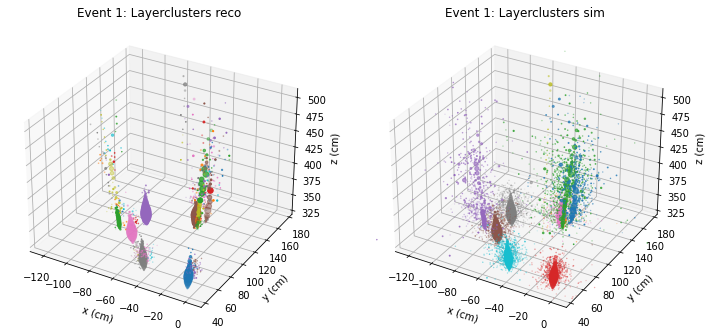

In [34]:
eid = 1

t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

precision, recall, fscore = evaluate(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, noise=False)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

reco_total = get_total_energy(t_energy, v_multi)
sim_total = get_total_energy(st_energy, sv_multi)
print(f"Simulated energy: {sim_total:.2f}, reconstructed energy: {reco_total:.2f} ({(reco_total / sim_total) * 100:.2f}%)")

plot_event(tracksters, simtracksters, eid, legend=False)

In [29]:
x_bary = tracksters["barycenter_x"].array()[eid]
y_bary = tracksters["barycenter_y"].array()[eid]
z_bary = tracksters["barycenter_z"].array()[eid]
X = np.array([x_bary, y_bary, z_bary]).T

Sanity check

In [14]:
# use the barycentres as seeds
seeds = X
kmeans = KMeans(n_clusters=len(seeds), init=seeds, n_init=1).fit(X)

evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, kmeans.labels_)

Precision: 0.97, Recall: 0.06, F-score: 0.11


## Extract features

Starting simple with trackster energy

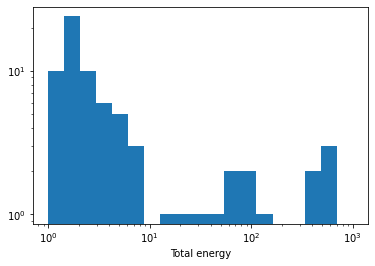

In [37]:
tre = [sum(e) for e in t_energy]

fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(111)
ax.set_xlabel("Total energy")
ax.hist(tre, bins=10**np.linspace(0, 3, 20))
ax.set_yscale("log")
ax.set_xscale("log")

plt.show()

Tracksters reco: 10, tracksters sim: 10
Precision: 0.91, Recall: 0.67, F-score: 0.77


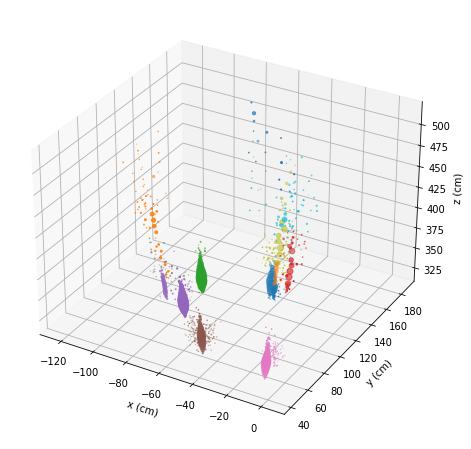

In [38]:
# only select higher energy tracksters
seeds = X[np.array(tre) > 25]
kmeans = KMeans(n_clusters=len(seeds), init=seeds, n_init=1).fit(X)

print(f"Tracksters reco: {max(kmeans.labels_)-1}, tracksters sim: {len(st_indexes)}")

evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, kmeans.labels_, noise=False)
plot_remapped(tracksters, eid, kmeans.labels_)

Tracksters reco: 11, tracksters sim: 10
Precision: 0.85, Recall: 0.66, F-score: 0.74


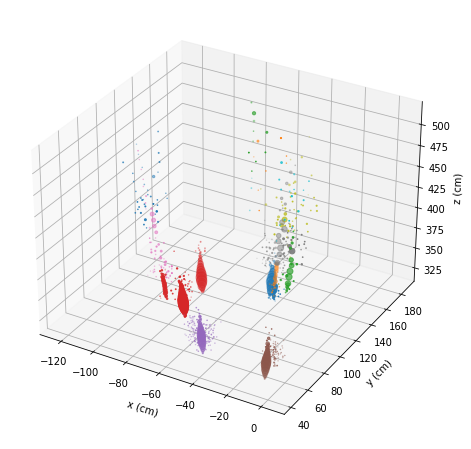

In [39]:
# First component of PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

tre = []
nve = []
centr = []
mlen = []
mdiff = []

cx = tracksters["vertices_x"].array()
cy = tracksters["vertices_y"].array()
cz = tracksters["vertices_z"].array()
ce = tracksters["vertices_energy"].array()

# extract features from a larger dataset
for ei in range(len(cx)):
    for x, y, z, e in zip(cx[ei], cy[ei], cz[ei], ce[ei]):   
        tre.append(sum(e))
        nve.append(len(e))
        G = create_graph(x, y, z, e, N=1)
        centr.append(longest_path_from_highest_centrality(G))
        mlen.append(mean_edge_length(G))
        mdiff.append(mean_edge_energy_gap(G))

scaler = StandardScaler()

feat = np.array((nve, tre, centr, mdiff, mlen)).T
feat_s = scaler.fit_transform(feat)

# fit in all data
pca = PCA(n_components=1).fit(feat_s)

# transform data from the event
data = pca.transform(feat_s[:len(cx[eid])])

seeds = X[data[:,0] > 2]
kmeans = KMeans(n_clusters=len(seeds), init=seeds, n_init=1).fit(X)

print(f"Tracksters reco: {max(kmeans.labels_)-1}, tracksters sim: {len(st_indexes)}")

evaluate_remapped(t_indexes, st_indexes, t_energy, st_energy, v_multi, sv_multi, kmeans.labels_, noise=False)
plot_remapped(tracksters, eid, kmeans.labels_)